## Finding the Best Classification Model for Intel Image Dataset

In [130]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.utils import shuffle
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import seaborn as sns

from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical   

import cv2
import csv
import os

import warnings
warnings.filterwarnings('ignore')

seed = 1234
np.random.seed(seed) 

### Import Data Images

In [131]:
## Image clean source: https://www.kaggle.com/code/uzairrj/beg-tut-intel-image-classification-93-76-accur

def get_images(path):
    IntelData, Labels = [], []
    
    for labels in os.listdir(path):
        for image_file in os.listdir(path+labels):
            image = cv2.imread(path+labels+r'/'+image_file)
            image = cv2.resize(image,(150,150))
            IntelData.append(image)
            Labels.append(Word_to_Label([labels][0]))
    return shuffle(IntelData,Labels,random_state=seed)
    
def Label_to_Word(label):
    label_dict = {0:"buildings", 1:"forest", 2:"glacier", 3:"mountain", 4:"sea", 5:"street"}
    return label_dict[label]

def Word_to_Label(word):
    word_dict = {"buildings": 0, "forest":1, "glacier":2, "mountain":3, "sea":4, "street":5}
    return word_dict[word]

In [132]:
## read training images

X_tr, y_tr = get_images('../IntelData/Data/seg_train/seg_train/')
X_tr = np.array(X_tr)
y_tr = np.array(y_tr)

X_te, y_te = get_images('../IntelData/Data/seg_test/seg_test/')
X_te = np.array(X_te)
y_te = np.array(y_te)


print(X_tr.shape, y_tr.shape)
print(X_te.shape, y_te.shape)


(14034, 150, 150, 3) (14034,)
(3000, 150, 150, 3) (3000,)


### Take a Glimpse at the Data

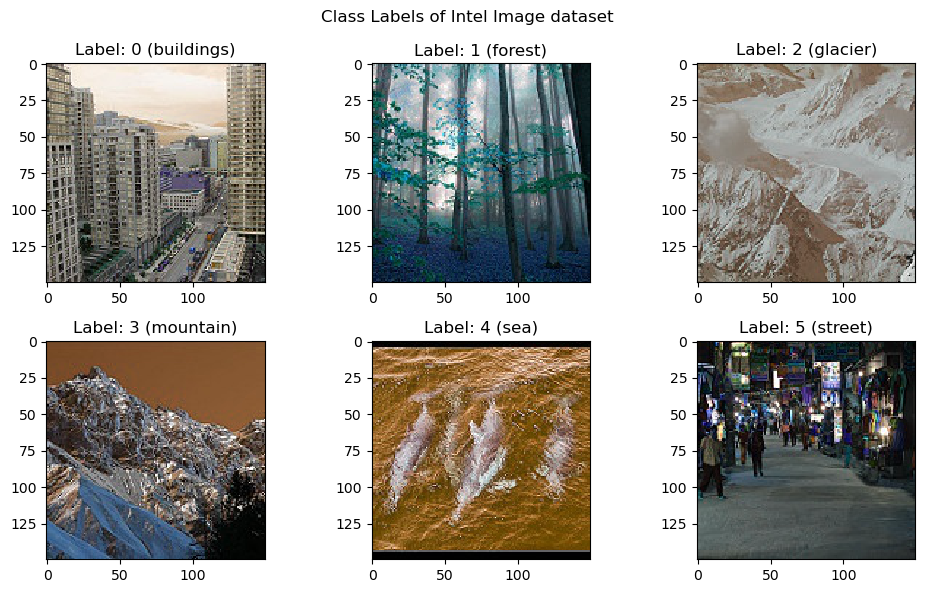

In [133]:
def find(arr, elem):
    for index, item in enumerate(arr):
        if item == elem:
            return index

figure, axes = plt.subplots(2, 3, figsize=(10, 6)) 

TrueLabels = {0:"buildings", 1:"forest", 2:"glacier", 3:"mountain", 4:"sea", 5:"street"}

i = 0
for x in range(2): 
    for y in range(3):
        index = find(y_tr, i)
        axes[x, y].imshow(X_tr[index]) 
        axes[x, y].set_title(f'Label: {i} ({TrueLabels[i]})') 
        i+= 1

plt.suptitle("Class Labels of Intel Image dataset")
plt.tight_layout() 


### Clean and Standardize Data

In [134]:
X_tr = np.reshape(X_tr, (14034,67500))
X_te = np.reshape(X_te, (3000,67500))

y_tr = y_tr.flatten()
y_te = y_te.flatten()

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_val = scaler.transform(X_val)

X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=0.20, random_state=seed, shuffle=True)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)

(11227, 67500) (11227,)
(2807, 67500) (2807,)


### Line Graph to Compare Results

In [152]:
def line_graph(x, y_train, y_val, title, x_label, y_label, color='blue', loc='upper right'):
    fig, axes = plt.subplots()

    axes.semilogx(x, y_train, linestyle='-', marker='x', color=color, label='Train')
    axes.semilogx(x, y_val, linestyle='--', marker='x', color=color, label='Validation')

    axes.legend(loc=loc)
    axes.set_xlabel(x_label, fontsize=14)
    axes.set_ylabel(y_label, fontsize=14)
    axes.set_title(title)
    return plt

### Make Confusion Matrix

In [135]:
def cm(y_pred, title):
    fig, ax = plt.subplots(figsize=(7, 5))

    sklearn_cm_eu = confusion_matrix(y_te, y_pred)
    sns.heatmap(sklearn_cm_eu, annot=True, ax=ax, fmt='g')

    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")

    ax.set_title(f"Confusion Matrix of Fashion-MNIST using {title}")
    return plt

### Record Results

In [136]:
def write_results(file, settings, headers):   
    with open(file, "a", newline='\n') as f:
        writer = csv.DictWriter(f, fieldnames=headers)
        writer.writerow(settings)

def view_results(file):
    df = pd.read_csv(file)
    return df

### Show Incorrect Predictions

In [137]:
def find_incorrect(predictions, true_label, predict_label):
    
    results = []
    length = len(y_te)
    for i in range(length):
        if y_te[i] == true_label and predictions[i] == predict_label:
            results.append(i)
        if len(results) == 10:
            return results

def print_incorrect(predictions, true_label, predict_label):
    
    indices = find_incorrect(predictions, true_label, predict_label)
    
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray' 
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    
    for i in range(10):
        axes[i//5, i%5].imshow(X_te[indices[i]].reshape(150, 150, 3))
        
    fig.suptitle(f"Images of {TrueLabels[true_label]} And Predicted As {TrueLabels[predict_label]}")
    plt.tight_layout()
    return plt

### Nearest Centroid

In [138]:
nc = NearestCentroid().fit(X_tr, y_tr)
train_predict = nc.predict(X_tr)
val_predict = nc.predict(X_val)
test_predict = nc.predict(X_te)

results = {"Train Accuracy": [0], "Validation Accuracy": [0], "Test Accuracy": [0]}

results["Train Accuracy"][0] = accuracy_score(y_tr, train_predict)
results["Validation Accuracy"][0] = accuracy_score(y_val, val_predict)
results["Test Accuracy"][0] = accuracy_score(y_te, test_predict)

df_nc = pd.DataFrame(results)

df_nc

Train Accuracy  Validation Accuracy  Test Accuracy
0        0.443217             0.444959       0.214333

In [139]:
df_nc.to_csv('./results/nc.csv', index=False)

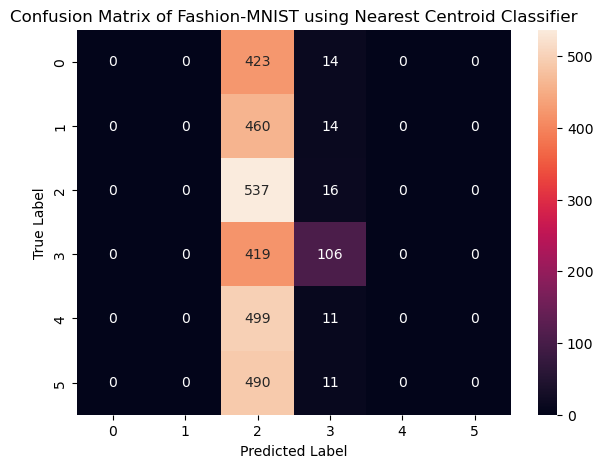

In [140]:
cm_knn = cm(test_predict, "Nearest Centroid Classifier")
cm_knn.show()

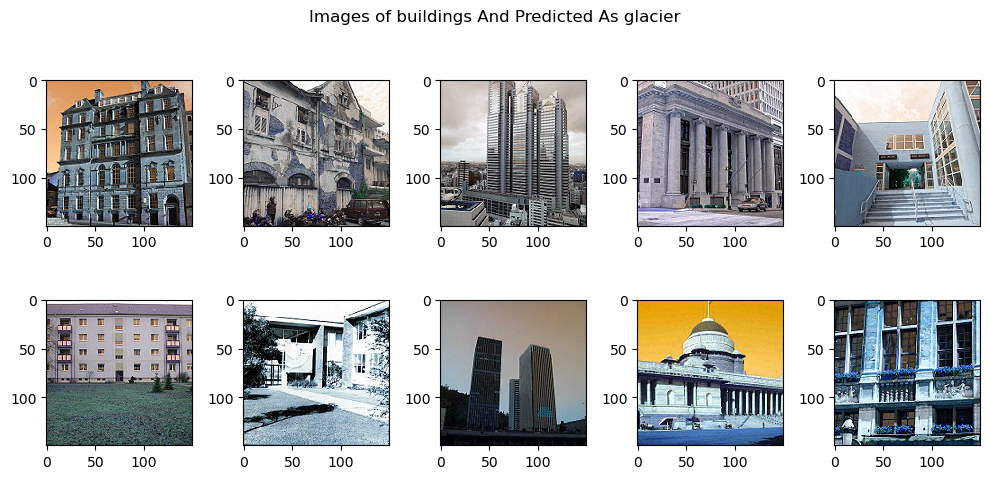

In [141]:
wrong_predictions = print_incorrect(test_predict, 0, 2)
wrong_predictions.show()

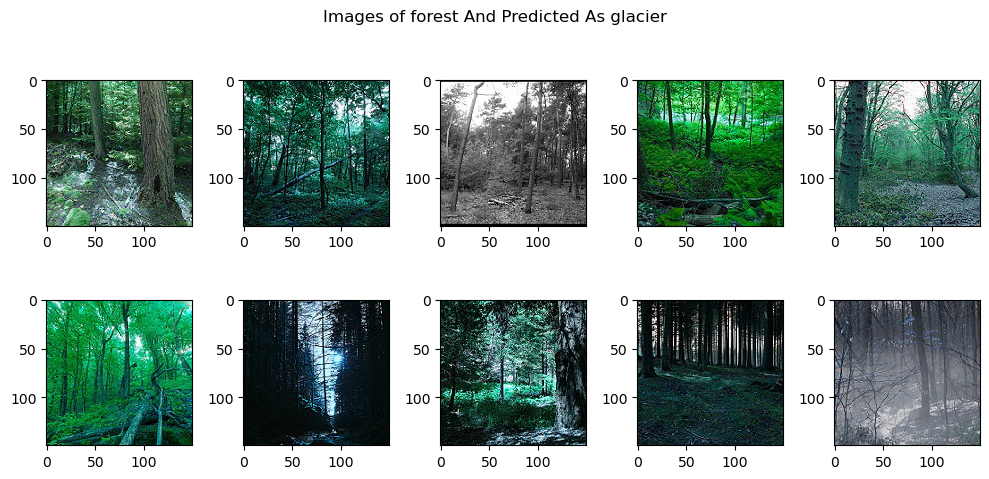

In [142]:
wrong_predictions = print_incorrect(test_predict, 1, 2)
wrong_predictions.show()

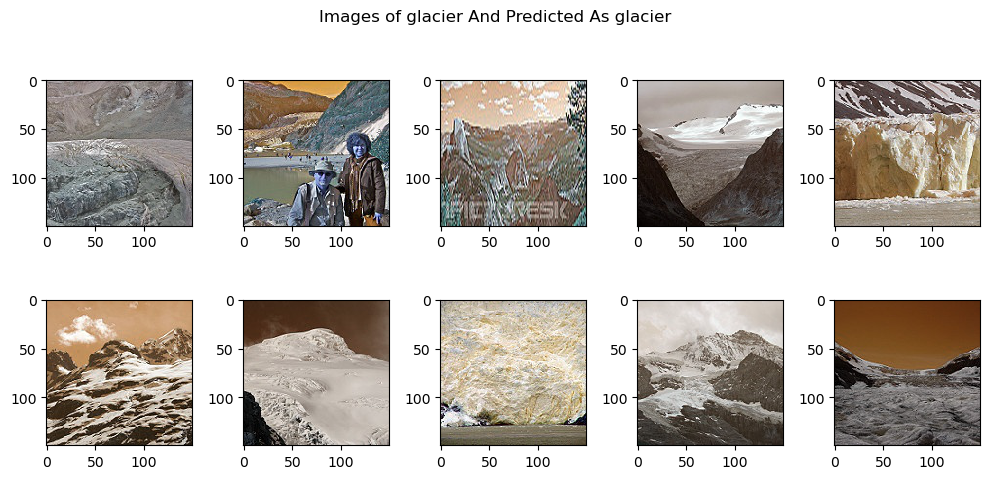

In [143]:
wrong_predictions = print_incorrect(test_predict, 2, 2)
wrong_predictions.show()

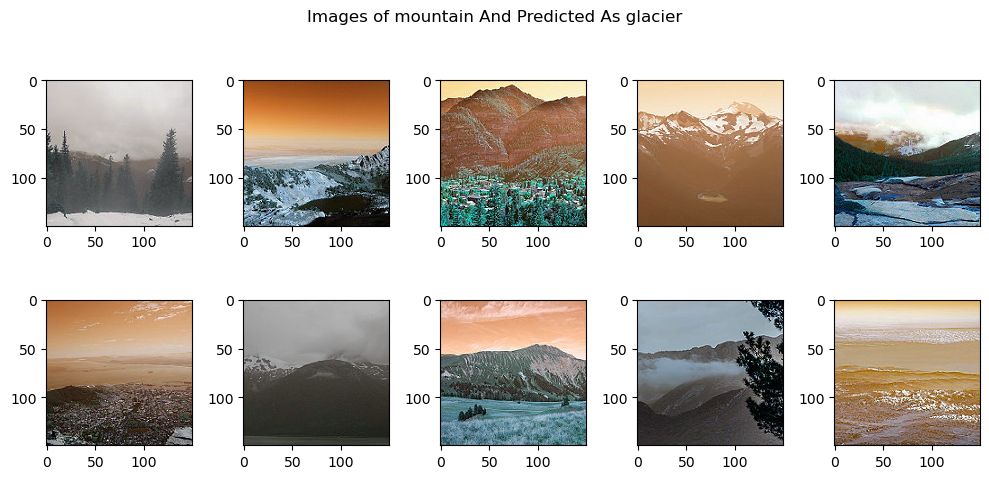

In [144]:
wrong_predictions = print_incorrect(test_predict, 3, 2)
wrong_predictions.show()

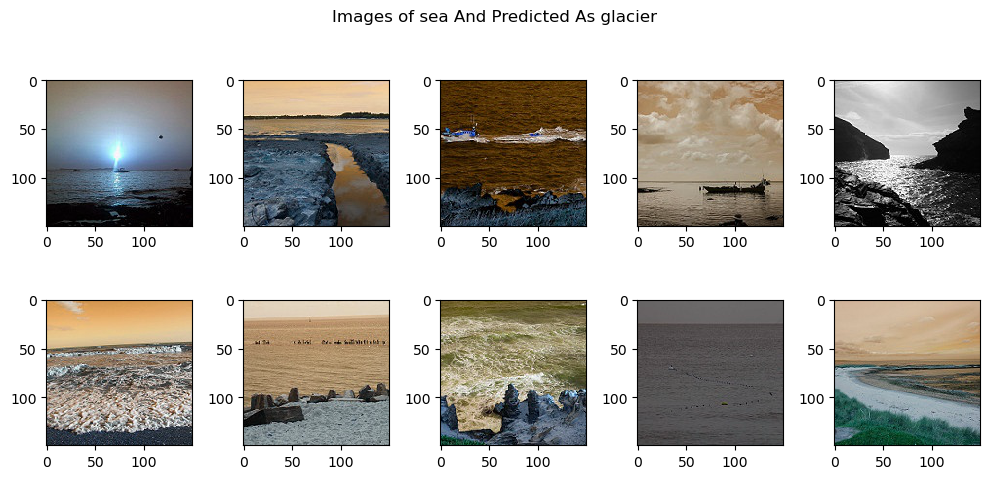

In [145]:
wrong_predictions = print_incorrect(test_predict, 4, 2)
wrong_predictions.show()

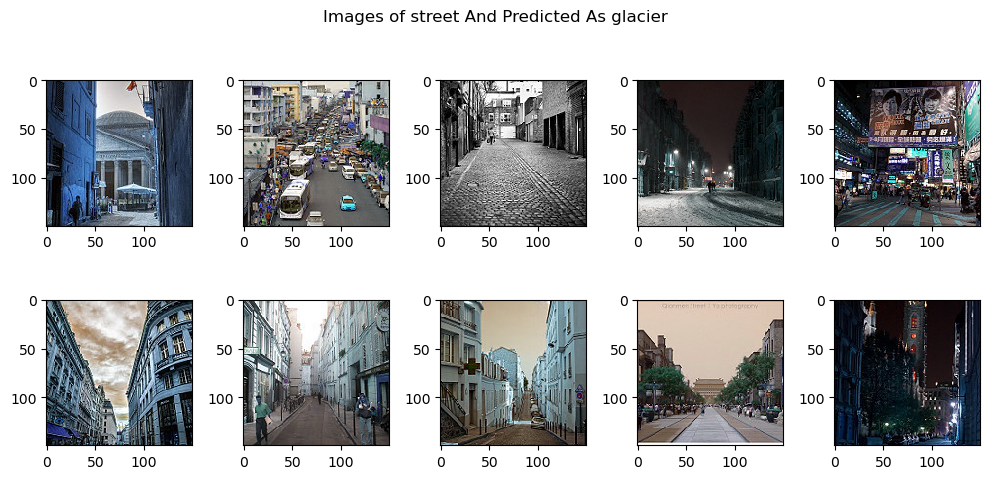

In [146]:
wrong_predictions = print_incorrect(test_predict, 5, 2)
wrong_predictions.show()

### KNN Classifier

In [149]:
def knnTrain(distance):

    HEADERS = ["K value", "Train Accuracy", "Validation Accuracy"]
    k_vals = [2, 5, 10, 15, 20, 30, 50]
    
    accuracies_train = np.zeros(len(k_vals))
    accuracies_val = np.zeros(len(k_vals))
    accuracies_test = np.zeros(len(k_vals))
    y_predictions = []
    
    for i, k in enumerate(k_vals):
        knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
        knn.fit(X_tr, y_tr)
        y_pred_train, y_pred_val, y_pred_test = knn.predict(X_tr), knn.predict(X_val), knn.predict(X_te)
        accuracies_train[i] = accuracy_score(y_tr, y_pred_train)
        accuracies_val[i] = accuracy_score(y_val, y_pred_val)
        accuracies_test[i] = accuracy_score(y_te, y_pred_test)
        y_predictions.append(y_pred_test)
        print(distance, k, accuracies_train[i], accuracies_val[i],accuracies_test[i])
    
    return accuracies_train, accuracies_val, accuracies_test, y_predictions

In [150]:
## predicting using 
k_vals = [2, 5, 10, 15, 20, 30, 50]
acc_train_eu, acc_val_eu, acc_test_eu, y_pred_eu = knnTrain('euclidean')

df_eu = pd.DataFrame({"K Value": k_vals, "Train Accuracy": acc_train_eu, 
                   "Validation Accuracy": acc_val_eu})
df_eu.style.set_caption("KNN Accuracy Using Euclidean Distance")

euclidean 2 0.7435646210029393 0.3452084075525472 0.16966666666666666
euclidean 5 0.45657789258038656 0.3694335589597435 0.19266666666666668
euclidean 10 0.40803420325999823 0.37228357677235485 0.21566666666666667
euclidean 15 0.40179923398948963 0.37727110794442464 0.21366666666666667
euclidean 20 0.39832546539592056 0.38368364802280014 0.21433333333333332
euclidean 30 0.40001781419791577 0.38902743142144636 0.20866666666666667
euclidean 50 0.4025118019061192 0.3979337370858568 0.21666666666666667


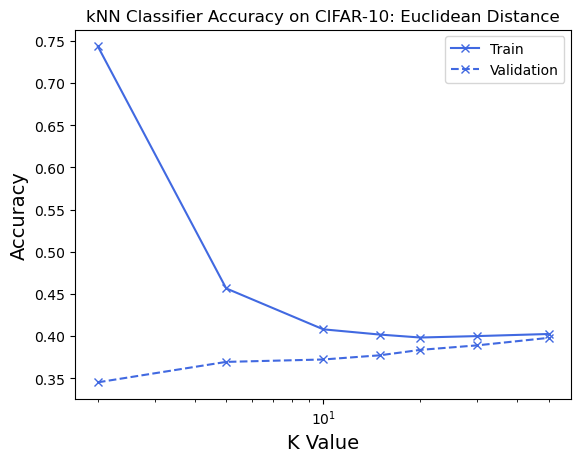

In [153]:
graph = line_graph(k_vals, acc_train_eu, acc_val_eu, 'kNN Classifier Accuracy on CIFAR-10: Euclidean Distance',
                  'K Value', 'Accuracy', 'royalblue')

graph.show()

In [154]:
df_eu["Test Accuracy"] = acc_test_eu
df_eu

K Value  Train Accuracy  Validation Accuracy  Test Accuracy
0        2        0.743565             0.345208       0.169667
1        5        0.456578             0.369434       0.192667
2       10        0.408034             0.372284       0.215667
3       15        0.401799             0.377271       0.213667
4       20        0.398325             0.383684       0.214333
5       30        0.400018             0.389027       0.208667
6       50        0.402512             0.397934       0.216667

In [155]:
df_eu.to_csv('./results/knn_eu.csv', index=False)

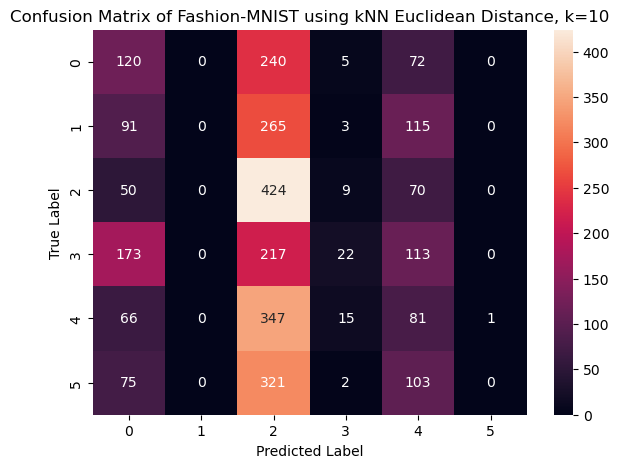

In [158]:
cm_knn = cm(y_pred_eu[2], "kNN Euclidean Distance, k=10")
cm_knn.show()

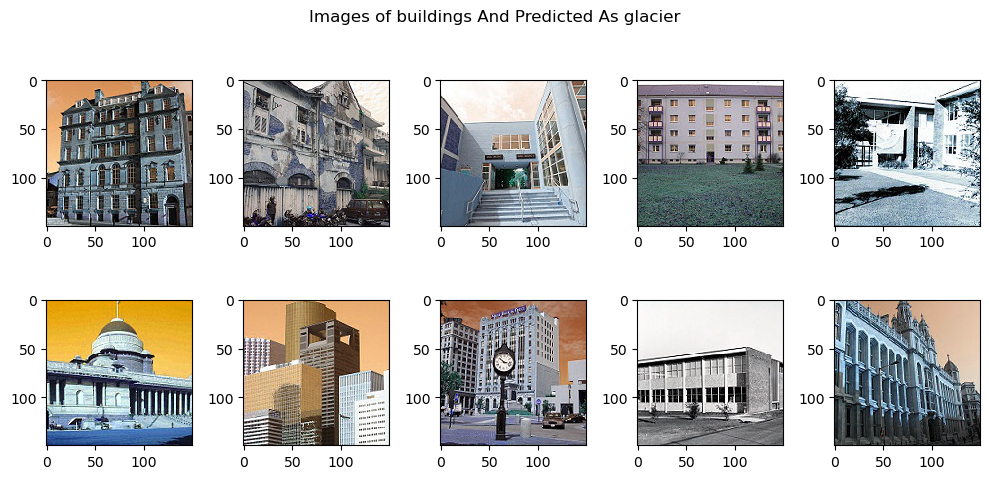

In [162]:
wrong_predictions = print_incorrect(y_pred_eu[2], 0, 2)
wrong_predictions.show()

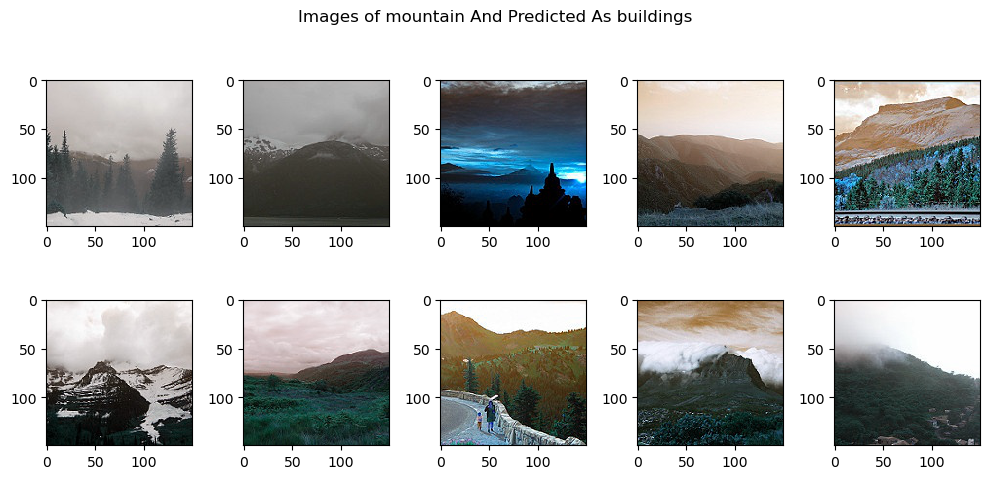

In [163]:
wrong_predictions = print_incorrect(y_pred_eu[2], 3, 0)
wrong_predictions.show()

### Neural Network